# One-time data analysis steps

Import your packages

In [57]:
import Pkg
# This installs only the modern, compatible versions
Pkg.add(["DataFrames", "CSV", "StatsPlots", "Statistics", "XLSX", "Dates", "StatsBase"])

   Resolving package versions...
    Updating `~/.julia/environments/v1.12/Project.toml`
  [2913bbd2] + StatsBase v0.34.10
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


Read in your file

In [ ]:
using DataFrames, CSV

filename = "backups/extracted/FY2025/All_Contracts_PrimeTransactions_2026-01-27_H16M01S18_1.csv"
# Using 'limit=10' to save your PC's energy
df = CSV.read(filename, DataFrame) #, limit=10000)
first(df, 5)



Row,contract_transaction_unique_key,contract_award_unique_key,award_id_piid,modification_number,transaction_number,parent_award_agency_id,parent_award_agency_name,parent_award_id_piid,parent_award_modification_number,federal_action_obligation,total_dollars_obligated,total_outlayed_amount_for_overall_award,base_and_exercised_options_value,current_total_value_of_award,base_and_all_options_value,potential_total_value_of_award,disaster_emergency_fund_codes_for_overall_award,outlayed_amount_from_COVID-19_supplementals_for_overall_award,obligated_amount_from_COVID-19_supplementals_for_overall_award,outlayed_amount_from_IIJA_supplemental_for_overall_award,obligated_amount_from_IIJA_supplemental_for_overall_award,action_date,action_date_fiscal_year,period_of_performance_start_date,period_of_performance_current_end_date,period_of_performance_potential_end_date,ordering_period_end_date,solicitation_date,awarding_agency_code,awarding_agency_name,awarding_sub_agency_code,awarding_sub_agency_name,awarding_office_code,awarding_office_name,funding_agency_code,funding_agency_name,funding_sub_agency_code,funding_sub_agency_name,funding_office_code,funding_office_name,treasury_accounts_funding_this_award,federal_accounts_funding_this_award,object_classes_funding_this_award,program_activities_funding_this_award,foreign_funding,foreign_funding_description,sam_exception,sam_exception_description,recipient_uei,recipient_duns,recipient_name,recipient_name_raw,recipient_doing_business_as_name,cage_code,recipient_parent_uei,recipient_parent_duns,recipient_parent_name,recipient_parent_name_raw,recipient_country_code,recipient_country_name,recipient_address_line_1,recipient_address_line_2,recipient_city_name,prime_award_transaction_recipient_county_fips_code,recipient_county_name,prime_award_transaction_recipient_state_fips_code,recipient_state_code,recipient_state_name,recipient_zip_4_code,prime_award_transaction_recipient_cd_original,prime_award_transaction_recipient_cd_current,recipient_phone_number,recipient_fax_number,primary_place_of_performance_country_code,primary_place_of_performance_country_name,primary_place_of_performance_city_name,prime_award_transaction_place_of_performance_county_fips_code,primary_place_of_performance_county_name,prime_award_transaction_place_of_performance_state_fips_code,primary_place_of_performance_state_code,primary_place_of_performance_state_name,primary_place_of_performance_zip_4,prime_award_transaction_place_of_performance_cd_original,prime_award_transaction_place_of_performance_cd_current,award_or_idv_flag,award_type_code,award_type,idv_type_code,idv_type,multiple_or_single_award_idv_code,multiple_or_single_award_idv,type_of_idc_code,type_of_idc,type_of_contract_pricing_code,type_of_contract_pricing,transaction_description,prime_award_base_transaction_description,action_type_code,action_type,solicitation_identifier,⋯
,String,String,String31,String7,Int64?,Int64?,String?,String31?,String31?,Float64,Float64,Float64?,Float64?,Float64?,Float64,Float64,String?,Float64?,Float64?,Missing,Missing,Date,Int64,Date,Date?,String31?,Date?,Date?,Int64,String31,Int64,String31,String7,String,Int64,String,String7,String,String7,String,String?,String?,String?,String?,String1,String31,Int64?,String?,String15,Missing,String,String,String?,String7?,String15?,Missing,String?,String?,String3,String15,String,String?,String31,Int64?,String31?,Int64?,String3,String31,String15,String7?,String7,String15?,String15?,String3?,String?,String31?,Int64?,String31?,Int64?,String3?,String31?,String15?,String7?,String7?,String7,String1?,String31?,String1?,String3?,String1?,String15?,String1?,String?,String1,String,String,String?,String1?,String?,String15?,⋯
1,9700_-NONE-_FA226323C0002_P00045_-NONE-_0,CONT_AWD_FA226323C0002_9700_-NONE-_-NONE-,FA226323C0002,P00045,0,missing,missing,missing,missing,7.77366e5,5.62032e7,missing,7.77366e5,5.65587e7,7.77366e5,1.82167e8,Q: Not Designated Nonemergency/Emergency/Disaster/Wildfire Suppression,missing,missing,mis

## Print ur data dicationary (complete)

In [ ]:
# 2. Look at the types
stats_df = describe(df, :eltype, :nmissing, :nunique, :min, :max, :median, :mean, :std)
CSV.write("FY2025-stats.csv", stats_df, transform=(col, val) -> something(val, missing)) 

Row,variable,eltype,nmissing,nunique,min,max,median,mean,std
,Symbol,Type,Int64,Union…,Any,Any,Any,Union…,Union…
1,contract_transaction_unique_key,String,0,107988,9700_-NONE-_F0470102C0002_P00789_-NONE-_0,9700_9700_W9113M22F0035_P00016_W9113M22D0062_0,,,
2,contract_award_unique_key,String,0,57969,CONT_AWD_0001_9700_FA300214D0004_9700,CONT_IDV_W9113M22D0062_9700,,,
3,award_id_piid,String31,0,57757,0001,W9126020F5001,,,
4,modification_number,String7,0,828,0,U00110,,,
5,transaction_number,"Union{Missing, Int64}",8966,,0,16,0.0,0.440609,2.31736
6,parent_award_agency_id,"Union{Missing, Int64}",42674,,300,9700,9700.0,8804.65,1854.95
7,parent_award_agency_name,"Union{Missing, String}",42674,11,DEPT OF DEFENSE,"VETERANS AFFAIRS, DEPARTMENT OF",,,
8,parent_award_id_piid,"Union{Missing, String31}",42674,7976,03310320D0223,W91WFU22A0001,,,
9,parent_award_modification_number,"Union{Missing, String31}",42674,609,0,U00016,,,


## Save the first 100 rows of data from a df (complete)

In [ ]:
# 2. Write it using a transform to handle 'nothing'
CSV.write("1000_rows_of_data.csv", df[1:100, :], transform=(col, val) -> something(val, missing))

"100_rows_of_data.csv"

## Extract Data Dictionary / Code Mapper

In [ ]:
using DataFrames, CSV

# 1. Create a folder for your lookup tables so they don't clutter your main folder
lookup_folder = "data/data_dictionaries"
mkpath(lookup_folder)

# 2. Automatically identify pairs
all_cols = names(df_latest)
pairs = []
seen_descriptions = []

for col in all_cols
    # We look for _code or _id as the "Key"
    if endswith(col, "_code") || endswith(col, "_id")
        prefix = replace(replace(col, "_code" => ""), "_id" => "")
        
        # Possible matches for the "Value"
        possible_matches = [prefix * "_description", prefix * "_name", prefix]
        
        for match in possible_matches
            if match in all_cols && match != col
                push!(pairs, col => match)
                push!(seen_descriptions, match)
                break
            end
        end
    end
end

println("Found $(length(pairs)) pairs. Exporting to /$lookup_folder...")

# 3. Export each pair to its own CSV with a Safety Guard
for pair in pairs
    code_col, desc_col = pair.first, pair.second
    
    # Create the mapping
    mapping = unique(dropmissing(df_latest[:, [code_col, desc_col]]))
    
    # Check if we actually have data before saving
    if nrow(mapping) > 0
        sort!(mapping, code_col)
        file_path = joinpath(lookup_folder, "$(code_col)_lookup.csv")
        CSV.write(file_path, mapping)
    else
        @warn "Skipping $code_col: No rows found with both a code and a description."
    end
end

println("✅ Done!")
println("📁 Lookups saved in: $lookup_folder")

# Data Cleaning Steps!

## vertical smushing
### Step 1: Remove duplicates and create stats file
1. sort by key and then modification number (descending)
2. group by the Unique Key and take the 'first' row of each group to represent the latest 
3. save the stats file

In [ ]:
using DataFrames

# 1. Sort by Key and then by Modification Number (descending)
# We convert modification_number to string/int carefully to ensure "10" comes after "2"
sort!(df, [:contract_award_unique_key, order(:modification_number, rev=true)])
# 2. Group by the Unique Key and take the 'first' row of each group
# Because we sorted 'rev=true', the 'first' row is the latest modification
df_latest = combine(groupby(df, :contract_award_unique_key), first)
# 3. Verify the counts match your 57,969 unique values
println("New row count: ", nrow(df_latest))
# 4. Look at the types
#describe(df, :eltype, :nunique)
latest_stats_df = describe(df_latest, :eltype, :nmissing, :nunique, :min, :max, :median, :mean, :std)
CSV.write("FY2025-stats-grouped-by-contract_award_unique_key.csv", latest_stats_df, transform=(col, val) -> something(val, missing)) 

New row count: 57969


## EDA steps (notepad)

In [60]:
using StatsBase
countmap(df_latest.parent_award_agency_name)

Dict{Union{Missing, String}, Int64} with 12 entries:
  missing                                           => 23050
  "FEDERAL ACQUISITION SERVICE"                     => 5844
  "NATIONAL OCEANIC AND ATMOSPHERIC ADMINISTRATION" => 1
  "DEPT OF THE AIR FORCE"                           => 5
  "LIBRARY OF CONGRESS"                             => 4
  "ENERGY, DEPARTMENT OF"                           => 5
  "PUBLIC BUILDINGS SERVICE"                        => 22
  "NATIONAL AERONAUTICS AND SPACE ADMINISTRATION"   => 2114
  "DEPT OF DEFENSE"                                 => 26818
  "U.S. CUSTOMS AND BORDER PROTECTION"              => 14
  "NATIONAL INSTITUTES OF HEALTH"                   => 10
  "VETERANS AFFAIRS, DEPARTMENT OF"                 => 82

In [61]:
# Create a simple True/False column: Is this a stand-alone contract?
df_latest.is_standalone = ismissing.(df_latest.parent_award_agency_name)

# Now check the average value difference
combine(groupby(df_latest, :is_standalone), :potential_total_value_of_award => mean)

Row,is_standalone,potential_total_value_of_award_mean
,Bool,Float64
1,false,1.04924e7
2,true,9.89733e8


In [62]:
using Statistics, DataFrames

# 1. Create the 'is_standalone' flag
# This returns true if there is no parent award (it's a direct DoD contract)
df_latest.is_standalone = ismissing.(df_latest.parent_award_agency_name)

# 2. Calculate the Stats
# We use skipmissing because potential_total_value often has blanks
analysis = combine(groupby(df_latest, :is_standalone), 
    nrow => :total_contracts,
    :potential_total_value_of_award => (x -> mean(skipmissing(x))) => :mean_value,
    :potential_total_value_of_award => (x -> median(skipmissing(x))) => :median_value
)

# 3. Display the results
show(analysis)

2×4 DataFrame
 Row │ is_standalone  total_contracts  mean_value  median_value 
     │ Bool           Int64            Float64     Float64      
─────┼──────────────────────────────────────────────────────────
   1 │         false            34919   1.04924e7     2.21759e5
   2 │          true            23050   9.89733e8     4.64679e5

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/paola/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/paola/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: Invalid negative or zero value -548145.8766157862 found at series index 1 for log10 based xscale
└ @ Plots /Users/paola/.julia/packages/Plots/GIume/src/utils.jl:105
┌ Warning: Invalid negative or zero value -1.6134659171978054e6 found at series index 1 for log10 based xscale
└ @ Plots /Users/paola/.julia/packages/Plots/GIume/src/utils.jl:105
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/paola/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/paola/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: Invalid negative or zero value -548145.8766157862 found at series index 1 for log10 based xscale
└ @ Plots /Users/paola/.julia/packages/Plots/GIume/src/utils.jl:105
┌ Warning: Invalid negative or ze

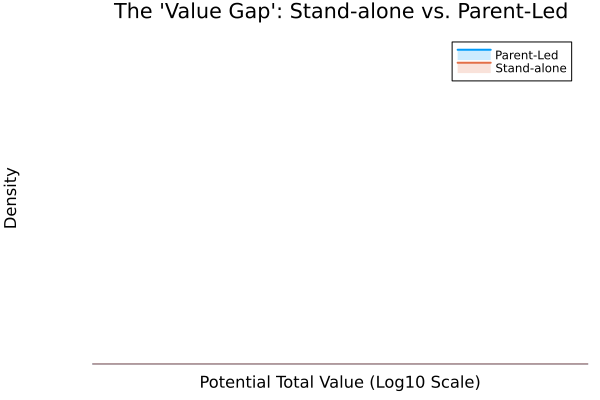

In [63]:
using StatsPlots

# 1. Filter out zeros/negatives to avoid log errors
plot_df = filter(row -> !ismissing(row.potential_total_value_of_award) && 
                        row.potential_total_value_of_award > 0, df_latest)

# 2. Create an overlapping Density Plot
# We use density instead of histogram because it's easier to see the overlap
@df plot_df density(
    :potential_total_value_of_award, 
    group = :is_standalone, 
    xaxis = :log10, 
    title = "The 'Value Gap': Stand-alone vs. Parent-Led",
    xlabel = "Potential Total Value (Log10 Scale)",
    ylabel = "Density",
    label = ["Parent-Led" "Stand-alone"],
    fill = (0, 0.2), # Adds a light transparent fill
    lw = 2
)

# Extracting just the 50 headers

In [8]:
using DataFrames, CSV
# 0. Set your filenames
names_csv = "manually_selected_50_column_headers.csv"
input_data_csv = "backups/extracted/FY2025/All_Contracts_PrimeTransactions_2026-01-27_H16M01S18_1.csv"
output_csv = "50_column_data.csv"

# 1. Load your list of 50 names
names_df = CSV.read(names_csv, DataFrame)

# Clean the names: convert to string, remove extra spaces (strip), and handle missing
target_columns = [strip(string(x)) for x in names_df[:, 1] if !ismissing(x)]

# 2. Get the headers from the BIG file without loading the data
# (Using limit=1 saves your Mac's RAM)
big_file_headers = names(CSV.read(input_data_csv, DataFrame, limit=1))

# Clean the big headers too, just in case
big_file_headers_clean = [strip(h) for h in big_file_headers]

# 3. Find the "Troublemakers"
missing_in_big_file = setdiff(target_columns, big_file_headers_clean)

if isempty(missing_in_big_file)
    println("✅ All 50 columns matched perfectly! Proceeding to filter...")
    df_subset = CSV.read(input_data_csv, DataFrame, select=target_columns)
    CSV.write(output_csv, df_subset)
    println("Done!")
else
    println("❌ The following $(length(missing_in_big_file)) columns were not found:")
    for col in missing_in_big_file
        println(" - '$col'")
    end
    
    # Optional: Look for "Close Matches" (case-insensitive check)
    println("\nSearching for case-insensitive matches...")
    for m in missing_in_big_file
        matches = filter(h -> lowercase(h) == lowercase(m), big_file_headers_clean)
        if !isempty(matches)
            println("Found match with different casing: '$m' -> should be '$(matches[1])'?")
        end
    end
end

✅ All 50 columns matched perfectly! Proceeding to filter...
Done!


# More data extraction. 
what i want this to do:
1. go thru datafile and keep only the columns i have listed in the column name column
2. get the datatypes of each column 
3. i have the ideal datatypes of each column listed in the column titled "ideal datatype" (float, date, or string)
4. convert the data in that column to its ideal type and do all steps necessary to do that
5. count the number of unique values in each column
6. if the count of unique values is low (less than 25) i want to see the proportion of each value in each category so i can make determination about what to do next. make plots for all of them, where each category is sorted high to low (bar chart or pie chart - whichever you think is better). if the number of unique values is higher than that, display a list of these columns 

# Phase 1
This phase focuses on memory efficiency. We only pull the columns you want and force them into the "Ideal" types you defined.

The Strategy:

Floats: Remove $, ,, and ( ) (often used for negative numbers in accounting).

Dates: Standardize into Julia Date objects. If a date is malformed, it becomes missing rather than crashing the script.

Strings: Force lowercase and trim whitespace to eliminate the "invisible duplicates" we discussed.

In [12]:
using CSV, DataFrames, Dates

# Load your manual instruction file
# Replace "my_column_list.csv" with your actual filename
instructions_df = CSV.read("data/manually_selected_column_headers_and_datatype_v3.csv", DataFrame)

# Convert the two columns into a Dictionary
# This assumes your CSV headers are exactly "column name" and "ideal type"
column_map = Dict(
    row["column name"] => Symbol(lowercase(strip(string(row["ideal type"])))) 
    for row in eachrow(instructions_df)
)

# Preview the map to make sure it looks right
println("Targeting $(length(keys(column_map))) columns.")

Targeting 41 columns.


In [13]:
instructions_df

Row,column name,ideal type
,String,String7
1,potential_total_value_of_award,float
2,period_of_performance_start_date,date
3,period_of_performance_current_end_date,date
4,period_of_performance_potential_end_date,date
5,solicitation_date,string
6,awarding_office_code,string
7,funding_office_code,string
8,object_classes_funding_this_award,string
9,program_activities_funding_this_award,string


In [14]:
function clean_and_load(data_filepath, col_map)
    println("Loading data from $data_filepath...")
    # Load only selected columns
    df = CSV.read(data_filepath, DataFrame, select=collect(keys(col_map)), stringtype=String)
    
    for (col_str, type) in col_map
        sym = Symbol(col_str)
        
        if type == :float
            df[!, sym] = map(x -> begin
                if ismissing(x) || x == "" || x == "NULL" return missing end
                s = replace(string(x), r"[$,\s]" => "")
                if startswith(s, "(") && endswith(s, ")") s = "-" * s[2:end-1] end
                tryparse(Float64, s)
            end, df[!, sym])

        elseif type == :integer
            df[!, sym] = map(x -> begin
                if ismissing(x) || x == "" return missing end
                # Strip commas in case integers are formatted (e.g., 1,000)
                s = replace(string(x), r"[,\s]" => "")
                tryparse(Int64, s)
            end, df[!, sym])

        elseif type == :boolean
            # Standardizes Y/N/Blank to true/false/missing
            df[!, sym] = map(x -> begin
                if ismissing(x) || x == "" return missing end
                s = uppercase(strip(string(x)))
                if s == "Y" || s == "TRUE" || s == "1" return true
                elseif s == "N" || s == "FALSE" || s == "0" return false
                else return missing end
            end, df[!, sym])
            
        elseif type == :date
            df[!, sym] = map(x -> begin
                if ismissing(x) || x == "" return missing end
                tryparse(Date, first(string(x), 10)) 
            end, df[!, sym])
            
        elseif type == :string
            df[!, sym] = map(x -> ismissing(x) ? missing : strip(lowercase(string(x))), df[!, sym])
        end
    end
    
    println("Load complete. Final dimensions: $(size(df))")
    return df
end

clean_and_load (generic function with 1 method)

In [27]:
# Execute the load
# Replace "usa_spending_full.csv" with your actual data file
input_data_csv = "backups/extracted/FY2025/All_Contracts_PrimeTransactions_2026-01-27_H16M01S18_1.csv"
df = clean_and_load(input_data_csv, column_map)



Loading data from backups/extracted/FY2025/All_Contracts_PrimeTransactions_2026-01-27_H16M01S18_1.csv...
Load complete. Final dimensions: (107988, 41)


Row,potential_total_value_of_award,period_of_performance_start_date,period_of_performance_current_end_date,period_of_performance_potential_end_date,solicitation_date,awarding_office_code,funding_office_code,object_classes_funding_this_award,program_activities_funding_this_award,foreign_funding_description,recipient_uei,recipient_duns,cage_code,prime_award_transaction_place_of_performance_state_fips_code,award_or_idv_flag,award_type_code,idv_type_code,multiple_or_single_award_idv_code,type_of_idc_code,type_of_contract_pricing_code,product_or_service_code,contract_bundling_code,naics_code,dod_acquisition_program_code,information_technology_commercial_item_category_code,extent_competed_code,solicitation_procedures_code,type_of_set_aside_code,evaluated_preference_code,research_code,other_than_full_and_open_competition_code,number_of_offers_received,commercial_item_acquisition_procedures_code,fed_biz_opps_code,price_evaluation_adjustment_preference_percent_difference,labor_standards_code,cost_or_pricing_data_code,government_furnished_property_code,undefinitized_action_code,performance_based_service_acquisition_code,multi_year_contract_code
,Float64,Date,Date?,Date?,SubStrin…?,SubStrin…,SubStrin…,SubStrin…?,SubStrin…?,SubStrin…,SubStrin…,Missing,SubStrin…?,Int64?,SubStrin…,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…,SubStrin…,SubStrin…?,Int64?,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…?,SubStrin…?,Int64?,SubStrin…,Bool?,Float64?,Bool?,Bool?,Bool,SubStrin…,Bool?,Bool?
1,1.82167e8,2022-11-04,2025-11-30,2032-11-30,2020-02-26,fa2263,f4ftml,25.7: operation and maintenance of equipment,0004: administration and service-wide activities,not applicable,lnkfgdhu6qz4,missing,2h984,39,award,d,missing,missing,missing,j,h266,h,541380,000,z,a,np,none,none,missing,missing,5,d,true,0.0,true,false,true,x,true,false
2,3.43816e7,2025-03-10,2029-03-09,2029-03-09,2024-10-17,fa2384,f4f4rh,25.7: operation and maintenance of equipment,0001: operation and maintenance,not applicable,c8zlj61yj528,missing,13993,39,award,d,missing,missing,missing,u,ac13,h,541715,000,z,a,br,none,none,missing,missing,1,d,missing,0.0,missing,true,false,x,true,false
3,3.61094e5,2025-02-19,2025-08-18,2026-02-18,2025-01-16,fa2396,f4fbbk,missing,missing,not applicable,kkz6vv15mbk7,missing,3yks5,39,award,d,missing,missing,missing,j,r499,h,541330,000,z,d,np,none,none,missing,one,1,a,missing,0.0,false,true,false,x,true,false
4,1.1e8,2023-07-28,missing,missing,2023-05-18,fa2280,f4fbeq,missing,missing,not applicable,hfbuflscbyl9,missing,8nt92,missing,idv,missing,b,s,b,1,ac32,h,541715,missing,missing,b,sss,none,none,sr3,oth,1,a,missing,missing,missing,false,false,x,true,false
5,5.23232e6,2024-09-16,2025-09-15,2026-09-15,2024-01-29,fa2401,f1afm1,25.5: research and development contracts,0020: undistributed,not applicable,ktmajcy6jxm3,missing,5ute0,6,award,d,missing,missing,missing,b,ac13,h,541715,000,z,c,sss,none,none,missing,one,1,d,missing,0.0,true,true,false,x,false,false
6,4.85381e5,2024-09-13,2025-05-05,2025-05-05,missing,fa2550,f3r1c0,missing,missing,not applicable,yztlalwm4uc7,missing,06ap0,46,award,b,missing,missing,missing,j,7e20,h,334118,000,a,f,sp1,sba,none,missing,missing,5,a,true,missing,missing,missing,false,x,missing,missing
7,10000.0,2025-07-20,2025-08-01,2025-08-01,missing,fa2384,f4fbat,missing,missing,not applicable,kc3ch2msk7q3,missing,85ld7,32,award,b,missing,missing,missing,j,ac14,h,541715,000,z,a,np,none,none,missing,missing,18,a,missing,missing,missing,missing,false,x,true,missing
8,5.35e7,2022-02-01,missing,missing,2021-02-22,fa2521,f3k0ka,missing,missing,not applicable,hwzds28aqb68,missing,856r8,missing,idv,missing,b,s,b,1,r425,h,541715,missing,missing,d,np,sba,none,missing,missing,2,d,missing,missing,true,false,true,x,true,true
9,4.51848e6,2023-09-25,2025-07-31,2025-07-31,2023-05-11,fa2521,f3k3dh,32.0: land and structures,0001: operating forces,not applicable,vukdaxzbmkc5,missing,59xc9,12,award,d,missing,missing,missing,j,z2pz

In [30]:
described_df = describe(df, :eltype, :nmissing, :nunique, :min, :max)

Row,variable,eltype,nmissing,nunique,min,max
,Symbol,Type,Int64,Union…,Any,Any
1,potential_total_value_of_award,Float64,0,,-4.94756e8,9.2e10
2,period_of_performance_start_date,Date,0,3109,1996-06-15,2032-09-29
3,period_of_performance_current_end_date,"Union{Missing, Date}",8966,3035,2002-12-31,2099-12-31
4,period_of_performance_potential_end_date,"Union{Missing, Date}",8966,3499,2002-12-31,2099-12-31
5,solicitation_date,"Union{Missing, SubString{String}}",31932,2412,2002-05-02,2025-09-30
6,awarding_office_code,SubString{String},0,327,fa0021,fa9550
7,funding_office_code,SubString{String},0,4009,70z008,wt6khu
8,object_classes_funding_this_award,"Union{Missing, SubString{String}}",70413,457,"11.1: full-time permanent;23.3: communications, utilities, and miscellaneous charges","41.0: grants, subsidies, and contributions"
9,program_activities_funding_this_award,"Union{Missing, SubString{String}}",70900,1094,0000: lease of dod real property;0001: operating forces;0004: administration and service-wide activities;0020: undistributed;00rb: reimbursable program,optn: field is optional prior to fy21


In [18]:
CSV.write("data/phase_1_analysis.csv", described_df; transform=(col, val) -> something(val, missing))

"data/phase_1_analysis.csv"

# Phase 2: Frequency Stats & The "Chop List"
This is where we apply the 5% Rule and look for Near-Zero Variance.
## The Strategy:
We calculate the "Sparsity" (Percentage of missing data).

In [ ]:
function analyze_sparsity_and_uniques(df)
    analysis_results = DataFrame(
        Column = Symbol[], 
        Unique_Count = Int[], 
        Missing_Pct = Float64[], 
        Top_Value_Pct = Float64[]
    )
    
    for col in names(df)
        vals = filter(!ismissing, df[!, col])
        u_count = length(unique(vals))
        m_pct = (count(ismissing, df[!, col]) / nrow(df)) * 100
        
        # Calculate how dominant the most common value is
        top_val_pct = 0.0
        if !isempty(vals)
            top_val_pct = (maximum(values(countmap(vals))) / length(vals)) * 100
        end
        
        push!(analysis_results, (Symbol(col), u_count, m_pct, top_val_pct))
    end
    return analysis_results
end

Phase 3: Visual Decision Breaks (Bar Charts vs. Lists)
For cost modeling, Bar Charts are superior to Pie Charts because they allow you to clearly see the "Long Tail" of smaller agencies or contractors.

The Strategy:

For < 25 Uniques: Generate a sorted horizontal bar chart. If the "Top 1" value is > 95%, the script will label it as a "Candidate for Deletion" (Near-Zero Variance).

For > 25 Uniques: Provide a "Pareto List" showing the Top 10 values and their cumulative percentage.

Phase 4: Feature Engineering (The Final Whittling)
This is where we consolidate the business flags and calculate time durations.

The Strategy:

Date Subtraction: Create duration_days.

Business Super-Flag: Create is_special_status.

The "Othering": For columns like recipient_name, any ID not in the Top 80% of volume gets renamed to "other_contractor".

Summary of Breaks
Break 1 (After Phase 2): You review the Sparsity Table. If a column you thought was important is 90% missing, you decide whether to drop it now.

Break 2 (After Phase 3): You look at the Bar Charts. You will see flags that are 99% "No." You can then run a command to drop those specific columns.

Break 3 (After Phase 4): You look at the final column list to ensure the "Othering" didn't delete too much detail.